# Imports

In [118]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Natural Language Toolkit

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

# Constants

In [143]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'


In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
# message = stream.read()
is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [4]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [5]:
for i in generate_squares(5):
    print(i, end=',')

0,1,4,9,16,

# Email body extraction

In [6]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames: 
            filepath = join(root,file_name)
            stream = open(filepath, encoding='latin-1')
            # message = stream.read()
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(lines)
            yield file_name, email_body

In [7]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, index=row_names)

In [8]:
spam_emails = df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
print(spam_emails.shape)
spam_emails.head()

(1898, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [9]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
print(ham_emails.shape)
ham_emails.head()

(3901, 2)


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [10]:
data = pd.concat([spam_emails,ham_emails])
print(data.shape)
data.head()

(5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning

In [12]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()
data['MESSAGE'].isnull().sum()

0

In [13]:
# Check if there are empty emails (string length zero)
data.loc[data['MESSAGE']==""]

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [14]:
data[data.MESSAGE.str.len() == 0].count()
data[data.MESSAGE.str.len() == 0].index
data[data.MESSAGE.str.len() == 0]

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [15]:
data.loc[data.index == 'cmds']

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


# Remove cmd files from Dataframe

In [16]:
data.drop(['cmds'], inplace=True)
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [17]:
document_ids = range(0,len(data.index))
data['DOC_ID'] = document_ids

In [18]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


# Save to File using Pandas

In [19]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages visualised (Pie charts)

In [20]:
data['CATEGORY'].value_counts()
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

In [21]:
(data['CATEGORY']==HAM_CAT).sum()

3900

In [22]:
sizes = [(data['CATEGORY']==SPAM_CAT).count(), (data['CATEGORY']==HAM_CAT).count()]

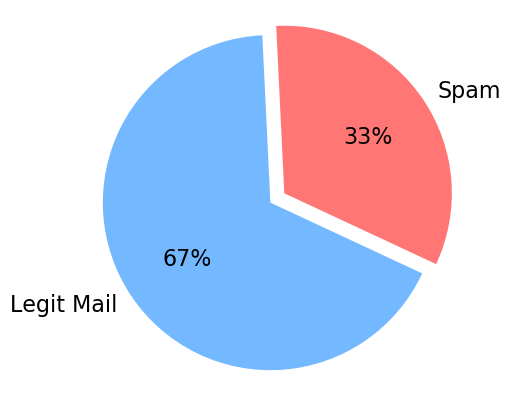

In [23]:
labels = ['Spam', 'Legit Mail']
# sizes = [(data['CATEGORY']==SPAM_CAT).sum(), (data['CATEGORY']==HAM_CAT).sum()]
sizes = [amount_of_spam, amount_of_ham]
# colors = ['gold', 'yellowgreen']
custom_colors = ['#ff7675','#74b9ff']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(5,5), dpi=100)
plt.pie(sizes,labels=labels,explode=explode, textprops={'fontsize':16},
        colors=custom_colors, autopct='%1.0f%%', startangle=-25)

plt.axis('equal')
plt.show()

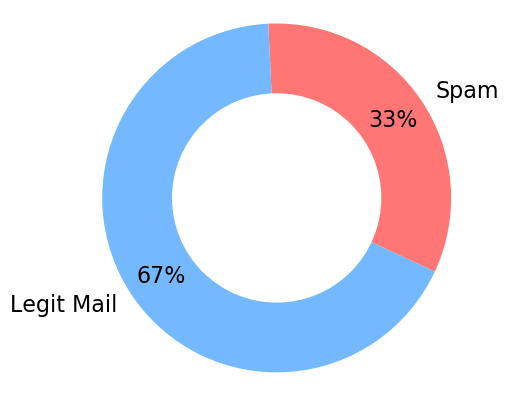

In [24]:
# Donut chart
labels = ['Spam', 'Legit Mail']
# sizes = [(data['CATEGORY']==SPAM_CAT).sum(), (data['CATEGORY']==HAM_CAT).sum()]
sizes = [amount_of_spam, amount_of_ham]
# colors = ['gold', 'yellowgreen']
custom_colors = ['#ff7675','#74b9ff']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(5,5), dpi=100)
plt.pie(sizes,labels=labels,textprops={'fontsize':16},
        colors=custom_colors, autopct='%1.0f%%', pctdistance=0.8, startangle=-25)

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

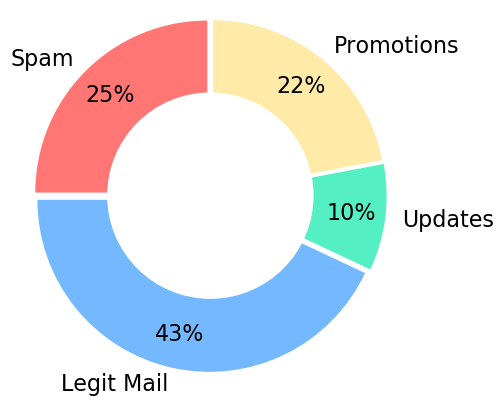

In [25]:
# Donut chart
labels = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
# sizes = [(data['CATEGORY']==SPAM_CAT).sum(), (data['CATEGORY']==HAM_CAT).sum()]
sizes = [25,43,10,22]
# colors = ['gold', 'yellowgreen']
custom_colors = ['#ff7675','#74b9ff','#55efc4','#ffeaa7']
explode = (0.025,0.025,0.025,0.025)  # explode 1st slice

# Plot
plt.figure(figsize=(5,5), dpi=100)
plt.pie(sizes,labels=labels,explode=explode,textprops={'fontsize':16},
        colors=custom_colors, autopct='%1.0f%%', pctdistance=0.8, startangle=90)

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

# Natural Language Processing

## Text Pre-Processing

### Download NLTK Resources (Tokenizer and Stop words)

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Gagan
[nltk_data]     Arora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Gagan
[nltk_data]     Arora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenizing

In [28]:
example_msg = "All work and no play makes Jack a dull boy. To be or not to be. \
               Nobody expects the Spanish Inquisition!"
word_tokenize(example_msg.lower())

['all',
 'work',
 'and',
 'no',
 'play',
 'makes',
 'jack',
 'a',
 'dull',
 'boy',
 '.',
 'to',
 'be',
 'or',
 'not',
 'to',
 'be',
 '.',
 'nobody',
 'expects',
 'the',
 'spanish',
 'inquisition',
 '!']

### Removing Stop Words

In [29]:
stop_words = set(stopwords.words('english'))

In [30]:
if 'in' in stop_words:
    print('Found it!')

Found it!


In [31]:
words = word_tokenize(example_msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
filtered_words



['work',
 'play',
 'makes',
 'jack',
 'dull',
 'boy',
 '.',
 '.',
 'nobody',
 'expects',
 'spanish',
 'inquisition',
 '!']

### Word Stems and Stemming

In [32]:
words = word_tokenize(example_msg.lower())
stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 '.',
 '.',
 'nobodi',
 'expect',
 'spanish',
 'inquisit',
 '!']

### Removing Punctuation

In [33]:
words = word_tokenize(example_msg.lower())
stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 'nobodi',
 'expect',
 'spanish',
 'inquisit']

### Removing HTML tags from email

In [34]:
data.at[13,'MESSAGE']

'<HTML><HEAD><TITLE>FREE Motorola Cell Phone with $50 Cash Back!</TITLE>\n\n<STYLE></STYLE>\n\n</HEAD>\n\n<BODY bgColor=#ffffff>\n\n<TABLE align="center" border=0 cellPadding=0 cellSpacing=0 width=450>\n\n  <TBODY>\n\n  <TR>\n\n    <TD><IMG height=1 src="images/spacer.gif" width=185></TD>\n\n    <TD><IMG height=1 src="images/spacer.gif" width=65></TD>\n\n    <TD><IMG height=1 src="images/spacer.gif" width=50></TD>\n\n    <TD><IMG height=1 src="images/spacer.gif" width=150></TD></TR>\n\n  <TR>\n\n    <TD colSpan=2 rowSpan=2><A href="http://theadmanager.com/server/c.asp?ad_key=QBFUIEXORXKL&ext=1"><IMG border=0\n\n      height=150\n\n      src="http://168.143.181.42/htmlemails/images/T193no_option_01.gif"\n\n      width=250></A></TD>\n\n    <TD rowSpan=2><A href="http://theadmanager.com/server/c.asp?ad_key=QBFUIEXORXKL&ext=1"><IMG border=0\n\n      height=150\n\n      src="http://168.143.181.42/htmlemails/images/T193no_option_02.gif"\n\n      width=50></A></TD>\n\n    <TD><A href="http://

In [35]:
soup = BeautifulSoup(data.at[13,'MESSAGE'], 'html.parser')
print(soup.prettify)

<bound method Tag.prettify of <html><head><title>FREE Motorola Cell Phone with $50 Cash Back!</title>
<style></style>
</head>
<body bgcolor="#ffffff">
<table align="center" border="0" cellpadding="0" cellspacing="0" width="450">
<tbody>
<tr>
<td><img height="1" src="images/spacer.gif" width="185"/></td>
<td><img height="1" src="images/spacer.gif" width="65"/></td>
<td><img height="1" src="images/spacer.gif" width="50"/></td>
<td><img height="1" src="images/spacer.gif" width="150"/></td></tr>
<tr>
<td colspan="2" rowspan="2"><a href="http://theadmanager.com/server/c.asp?ad_key=QBFUIEXORXKL&amp;ext=1"><img border="0" height="150" src="http://168.143.181.42/htmlemails/images/T193no_option_01.gif" width="250"/></a></td>
<td rowspan="2"><a href="http://theadmanager.com/server/c.asp?ad_key=QBFUIEXORXKL&amp;ext=1"><img border="0" height="150" src="http://168.143.181.42/htmlemails/images/T193no_option_02.gif" width="50"/></a></td>
<td><a href="http://theadmanager.com/server/c.asp?ad_key=QBFUIE

In [36]:
soup.get_text()

'FREE Motorola Cell Phone with $50 Cash Back!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n*Free phone\n\n      offer subject to VoiceStream Wireless credit approval. Must activate a new\n\n      line of service to receive a free phone. A one-time activation fee of $25\n\n      applies to all new activations. Coverage not available in all areas. Offer\n\n      fulfilled by SimplyWireless.com, a VoiceStream authorized dealer. See site\n\n      for additional offer details.\n\n      **$50 mail-in rebate is available for new VoiceStream service plans\n\n      $29.99 and greater. Rebate ends\n\n8/31/02.\n\n\n\n\nYou are receiving this mailing because you are a\n\nmember of SendGreatOffers.com and subscribed as:JM@NETNOTEINC.COM\n\nTo unsubscribe \nClick Here\n\n(http://admanmail.com/subscription.asp?em=JM@NETNOTEINC.COM&l=SGO)\n\nor reply to this email with REMOVE in the subject line - you must\n\nalso include the body of this message to be unsubscribed. Any corresp

### Functions for Email Processing

In [37]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    # Converts to lower case and splits up the words
    words = word_tokenize(message.lower())
    filtered_words = []
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
    return filtered_words

In [38]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [39]:
def clean_message_no_html(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    # Remove HTML Tags
    soup = BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
    return filtered_words

In [40]:
clean_message_no_html(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [41]:
data.at[2,'MESSAGE'] # Works of names
data.iat[2,0] # Works of location
data.iloc[0:2] 
data.loc[0:2] 
data.MESSAGE.iloc[0:3]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

# Apply Cleaning and Tokenization

### Slicing Dataframe and Series and Creating Subsets

In [42]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [43]:
# flat_list = []

# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
        
# len(flat_list)

flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

321

In [44]:

nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\Gagan Arora\.conda\envs\Custom\lib\site-packages\bs4\__init__.py:398: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup


In [45]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [46]:
doc_ids_spam = data[data.CATEGORY==1].index
doc_ids_ham = data[data.CATEGORY==0].index

In [47]:
doc_ids_spam.values

array([   0,    1,    2, ..., 1893, 1894, 1895], dtype=int64)

#### Subsetting a Series with an Index

In [48]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

In [49]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [61]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words[:10]

email     3090
http      3087
free      2555
click     2055
receiv    1987
list      1971
get       1903
pleas     1837
busi      1792
order     1743
dtype: int64

# Creating a Wordcloud

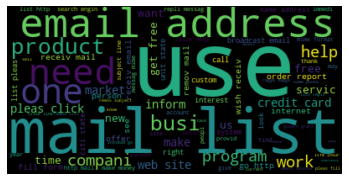

In [60]:
del(word_cloud)
word_cloud = WordCloud().generate(' '.join(flat_list_spam))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [63]:
word_cloud.words_

{'use': 1.0,
 'mail list': 0.7518518518518519,
 'email address': 0.7012345679012346,
 'need': 0.5518518518518518,
 'one': 0.5148148148148148,
 'product': 0.49506172839506174,
 'busi': 0.4654320987654321,
 'program': 0.45555555555555555,
 'work': 0.45185185185185184,
 'compani': 0.445679012345679,
 'help': 0.43703703703703706,
 'pleas click': 0.4308641975308642,
 'web site': 0.4308641975308642,
 'credit card': 0.40987654320987654,
 'inform': 0.3962962962962963,
 'make': 0.39012345679012345,
 'market': 0.3851851851851852,
 'us': 0.3530864197530864,
 'time': 0.34814814814814815,
 'new': 0.3432098765432099,
 'want': 0.3432098765432099,
 'free': 0.3345679012345679,
 'servic': 0.3296296296296296,
 'get free': 0.3296296296296296,
 'order report': 0.32592592592592595,
 'receiv email': 0.32469135802469135,
 'receiv mail': 0.31851851851851853,
 'internet': 0.3172839506172839,
 'person': 0.3160493827160494,
 'remov mail': 0.3160493827160494,
 'see': 0.3111111111111111,
 'go http': 0.3111111111111

In [91]:
del(word_cloud)

In [113]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

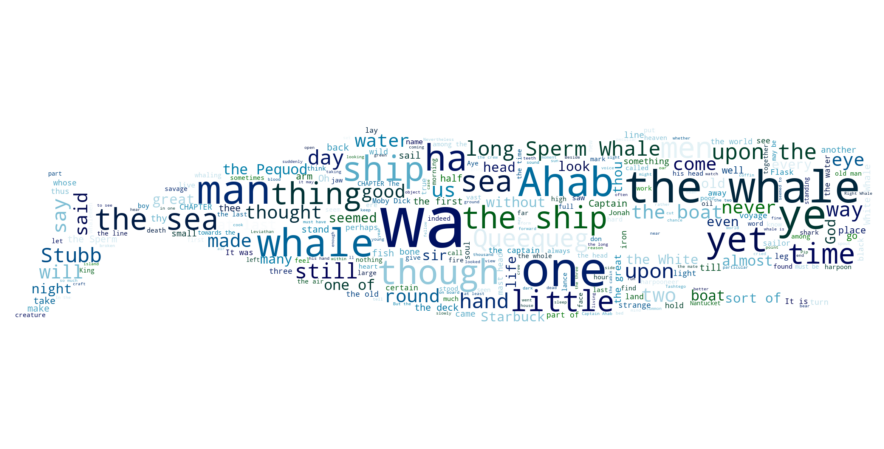

In [114]:
icon = Image.open(WHALE_FILE)
# blank canvas
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #converts the image object to an array
word_cloud = WordCloud(mask=rgb_array, background_color='white',max_words=300, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Hamlet Skull Wordcloud

In [115]:
example_corpus_2 = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list_2 = [''.join(word) for word in example_corpus_2]
novel_as_string_2 = ' '.join(word_list_2)

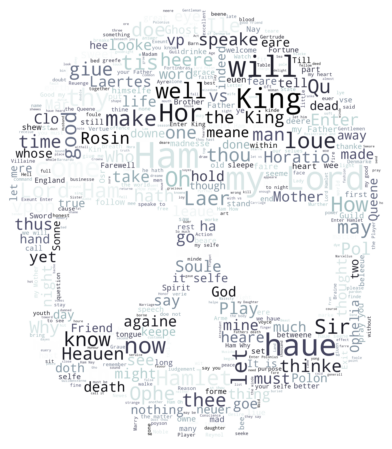

In [116]:
skull_icon = Image.open(SKULL_FILE)
# blank canvas
skull_image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255,255,255))
skull_image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(skull_image_mask) #converts the image object to an array
word_cloud_2 = WordCloud(mask=rgb_array, background_color='white',max_words=500, colormap='bone')
word_cloud_2.generate(novel_as_string_2)

plt.figure(figsize=(16,8))
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

# Wordcloud of Ham and Spam messages

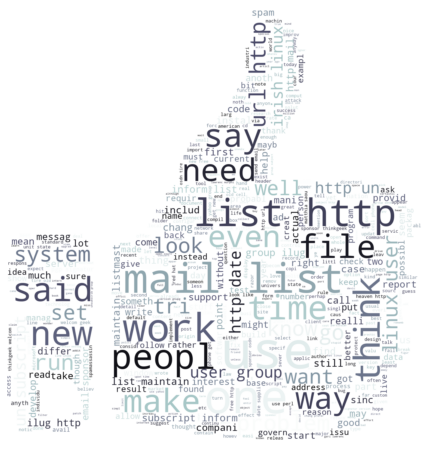

In [120]:
thumbs_up_icon = Image.open(THUMBS_UP_FILE)
# blank canvas
thumbs_up_image_mask = Image.new(mode='RGB', size=thumbs_up_icon.size, color=(255,255,255))
thumbs_up_image_mask.paste(thumbs_up_icon, box=thumbs_up_icon)
rgb_array = np.array(thumbs_up_image_mask) #converts the image object to an array

ham_str = ' '.join(flat_list_ham)
word_cloud_2 = WordCloud(mask=rgb_array, background_color='white',max_words=500, colormap='bone')
word_cloud_2.generate(ham_str)

plt.figure(figsize=(16,8))
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [121]:
def clean_message_no_html_without_stemmer(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    # Remove HTML Tags
    soup = BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(word)
    return filtered_words

In [122]:
nested_list_without_stemmer = data.MESSAGE.apply(clean_message_no_html_without_stemmer)

C:\Users\Gagan Arora\.conda\envs\Custom\lib\site-packages\bs4\__init__.py:398: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup


In [124]:
spam_list = nested_list_without_stemmer.loc[doc_ids_spam]
ham_list = nested_list_without_stemmer.loc[doc_ids_ham]
spam_list_2 = [item for sublist in spam_list for item in sublist]
ham_list_2 = [item for sublist in ham_list for item in sublist]



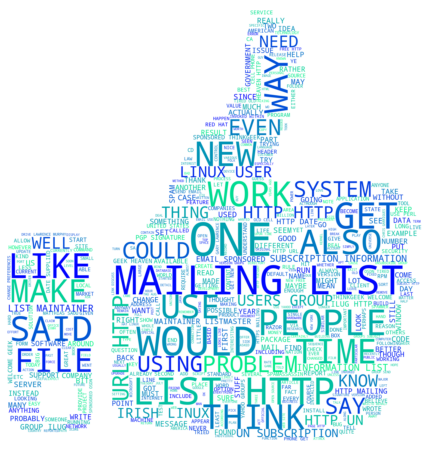

In [135]:
thumbs_up_icon = Image.open(THUMBS_UP_FILE)
# blank canvas
thumbs_up_image_mask = Image.new(mode='RGB', size=thumbs_up_icon.size, color=(255,255,255))
thumbs_up_image_mask.paste(thumbs_up_icon, box=thumbs_up_icon)
rgb_array = np.array(thumbs_up_image_mask) #converts the image object to an array

ham_str = ' '.join(ham_list_2)
word_cloud_2 = WordCloud(mask=rgb_array, background_color='white',max_words=500, colormap='winter')
word_cloud_2.generate(ham_str.upper())

plt.figure(figsize=(16,8))
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

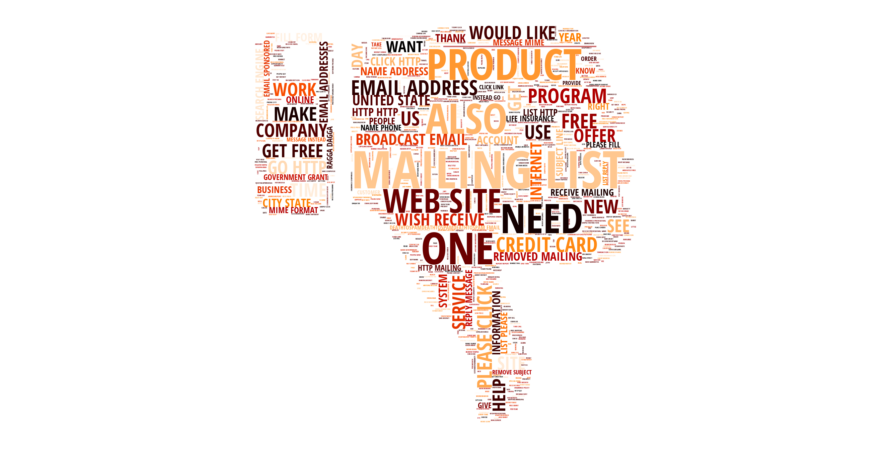

In [134]:
thumbs_down_icon = Image.open(THUMBS_DOWN_FILE)
# blank canvas
thumbs_down_image_mask = Image.new(mode='RGB', size=thumbs_down_icon.size, color=(255,255,255))
thumbs_down_image_mask.paste(thumbs_down_icon, box=thumbs_down_icon)
rgb_array = np.array(thumbs_down_image_mask) #converts the image object to an array

spam_str = ' '.join(spam_list_2)
word_cloud_2 = WordCloud(mask=rgb_array, background_color='white',max_font_size=300,
                         max_words=800, colormap='gist_heat',font_path=CUSTOM_FONT_FILE)
word_cloud_2.generate(spam_str.upper())

plt.figure(figsize=(16,8))
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary and Dictionary

In [136]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [139]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])

Number of unique words 27218


In [144]:
frequent_words = unique_words[:VOCAB_SIZE]
frequent_words[:10]

http     10648
use       5015
list      4849
email     4366
get       4187
mail      3983
one       3905
free      3171
time      3041
work      2880
dtype: int64

# Create Vocabulary DataFrame with a WORD_ID

In [146]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values,'FREQ': frequent_words.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD,FREQ
WORD_ID,,
0,http,10648
1,use,5015
2,list,4849
3,email,4366
4,get,4187


In [165]:
vocab_set = set(vocab.VOCAB_WORD)
word = 'learn'
if word in vocab_set:
    print('yes')
else:
    print('no')



yes


In [184]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
max_loc = np.argmax(clean_email_lengths)

In [185]:
data.at[max_loc,'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp